# Machine Learning and Statistics for Physicists

## Homework 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

### Problem 1

Use `np.einsum` to evaluate the tensor expression $g^{il} \Gamma^m_{ki} x^k$ which arises in [contravariant derivatives in General Relativity](https://en.wikipedia.org/wiki/Christoffel_symbols#Covariant_derivatives_of_tensors).  Note we are using the GR convention that repeated indices (k,l) are summed over.

In [2]:
def tensor_expr(g, Gamma, x, D=4):
    """Evaluate the tensor expression above.
    
    Parameters
    ----------
    g : array
        Numpy array of shape (D, D)
    Gamma : array
        Numpy array of shape (D, D, D)
    x : array
        Numpy array of shape (D,)
    D : int
        Dimension of input tensors.
        
    Returns
    -------
    array
        Numpy array of shape (D, D) that evaluates the tensor expression.
    """
    assert g.shape == (D, D)
    assert Gamma.shape == (D, D, D)
    assert x.shape == (D,)

    GG = np.einsum("il, mki -> lmk", g, Gamma)
    
    return np.einsum("lmk, k -> lm", GG, x)

In [3]:
# A correct solution should pass these tests.
g = np.arange(4 ** 2).reshape(4, 4)
Gamma = np.arange(4 ** 3).reshape(4, 4, 4)
x = np.arange(4)
y = tensor_expr(g, Gamma, x)
assert np.array_equal(
    y,
    [[ 1680,  3984,  6288,  8592], [ 1940,  4628,  7316, 10004],
     [ 2200,  5272,  8344, 11416], [ 2460,  5916,  9372, 12828]])

### Problem 2

Use `np.histogram` to calculate the [probability density](https://en.wikipedia.org/wiki/Probability_density_function) that values in an arbitrary input data array fall within user-specified bins. Hint: `np.histogram` does all the work for you with the correct arguments.

In [4]:
def estimate_probability_density(data, bins):
    """Estimate the probability density of arbitrary data.
    
    Parameters
    ----------
    data : array
        1D numpy array of random values.
    bins : array
        1D numpy array of N+1 bin edges to use. Must be increasing.

    Returns
    -------
    array
        1D numpy array of N probability densities.
    """
    assert np.all(np.diff(bins) > 0)
    PDF = np.histogram(data,bins,density=True)
    return PDF[0]

In [5]:
# A correct solution should pass these tests.
generator = np.random.RandomState(seed=123)
data = generator.uniform(size=100)
bins = np.linspace(0., 1., 11)
rho = estimate_probability_density(data, bins)
assert np.allclose(rho, [ 0.6,  0.8,  0.7,  1.7,  1.1,  1.3,  1.6,  0.9,  0.8,  0.5])
data = generator.uniform(size=1000)
bins = np.linspace(0., 1., 101)
rho = estimate_probability_density(data, bins)
dx = bins[1] - bins[0]
assert np.allclose(dx * rho.sum(), 1.)

### Problem 3

Define a function to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_estimation) $H(\rho)$ of a binned probability density, defined as:
$$
H(\rho) \equiv -\sum_i \rho_i \log(\rho_i) \Delta w_i \; ,
$$
where $\rho_i$ is the binned density in bin $i$ with width $w_i$.

In [6]:
def binned_entropy(rho, bins):
    """Calculate the binned entropy.
    
    Parameters
    ----------
    rho : array
        1D numpy array of densities, e.g., calculated by the previous function.
    bins : array
        1D numpy array of N+1 bin edges to use. Must be increasing.

    Returns
    -------
    float
        Value of the binned entropy.
    """
    assert np.all(np.diff(bins) > 0)
    logrho = np.log(rho)
    binsp = np.roll(bins,-1)
    dwp = binsp - bins
    dw = np.delete(dwp,-1)
    h = -rho*logrho*dw
    return np.sum(h)

In [7]:
# A correct solution should pass these tests.
generator = np.random.RandomState(seed=123)
data1 = generator.uniform(size=10000)
data2 = generator.uniform(size=10000) ** 4
bins = np.linspace(0., 1., 11)
rho1 = estimate_probability_density(data1, bins)
rho2 = estimate_probability_density(data2, bins)
H1 = binned_entropy(rho1, bins)
H2 = binned_entropy(rho2, bins)
assert np.allclose(H1, -0.000801544)
assert np.allclose(H2, -0.699349908)

### Problem 4

The normal (aka Gaussian) distribution is one of the fundamental probability densities that we will encounter often.

Implement the function below using `np.random.multivariate_normal` to generate random samples from an arbitrary multidimensional normal distribution, for a specified random seed:

In [8]:
def generate_normal(mu, C, n, seed=123):
    """Generate random samples from a normal distribution.
    
    Parameters
    ----------
    mu : array
        1D array of mean values of length N.
    C : array
        2D array of covariances of shape (N, N). Must be a positive-definite matrix.
    n : int
        Number of random samples to generate.
    seed : int
        Random number seed to use.
        
    Returns
    -------
    array
        2D array of shape (n, N) where each row is a random N-dimensional sample.
    """
    assert len(mu.shape) == 1, 'mu must be 1D.'
    assert C.shape == (len(mu), len(mu)), 'C must be N x N.'
    assert np.all(np.linalg.eigvals(C) > 0), 'C must be positive definite.'
    np.random.seed(seed)
    return np.random.multivariate_normal(mu, C, size=n)
    

In [9]:
# A correct solution should pass these tests.
mu = np.array([-1., 0., +1.])
C = np.identity(3)
C[0, 1] = C[1, 0] = -0.9
Xa = generate_normal(mu, C, n=500, seed=1)
Xb = generate_normal(mu, C, n=500, seed=1)
Xc = generate_normal(mu, C, n=500, seed=2)
assert np.array_equal(Xa, Xb)
assert not np.array_equal(Xb, Xc)
X = generate_normal(mu, C, n=2000, seed=3)
assert np.allclose(np.mean(X, axis=0), mu, rtol=0.001, atol=0.1)
assert np.allclose(np.cov(X, rowvar=False), C, rtol=0.001, atol=0.1)

Run the cell below to visualize a generated 3D dataset:

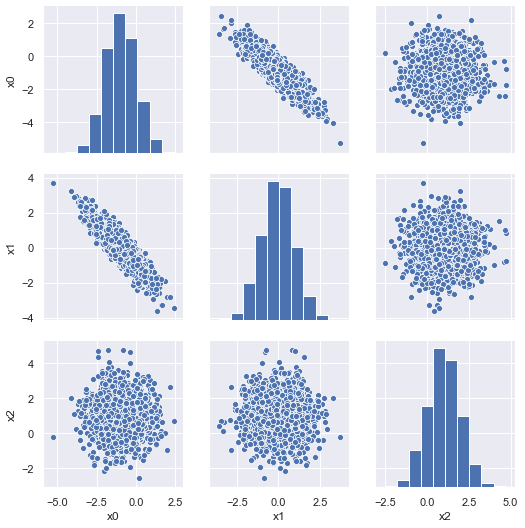

In [10]:
def visualize_3d():
    mu = np.array([-1., 0., +1.])
    C = np.identity(3)
    C[0, 1] = C[1, 0] = -0.9
    X = generate_normal(mu, C, n=2000, seed=3)
    df = pd.DataFrame(X, columns=('x0', 'x1', 'x2'))
    sns.pairplot(df)
    
visualize_3d()

Read about [correlation and covariance](https://en.wikipedia.org/wiki/Covariance_and_correlation), then implement the function below to create a 2x2 covariance matrix given values of $\sigma_x$, $\sigma_y$ and the correlation coefficient $\rho$:

In [11]:
def create_2d_covariance(sigma_x, sigma_y, rho):
    """Create and return the 2x2 covariance matrix specified by the input args.
    """
    assert (sigma_x > 0) and (sigma_y > 0), 'sigmas must be > 0.'
    sigma_xy = rho*sigma_x*sigma_y
    sigma_xx = sigma_x*sigma_x
    sigma_yy = sigma_y*sigma_y
    cv = np.array([sigma_xx,sigma_xy,sigma_xy,sigma_yy])
    return cv.reshape(2,2)

In [12]:
# A correct solution should pass these tests.
assert np.array_equal(create_2d_covariance(1., 1., 0.0), [[1., 0.], [0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., 0.0), [[4., 0.], [0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., 0.5), [[4., 1.], [1., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., -0.5), [[4., -1.], [-1., 1.]])

Run the following cell that uses your `create_2d_covariance` and `generate_normal` functions to compare the 2D normal distributions with $\rho = 0$ (blue), $\rho = +0.9$ (red) and $\rho = -0.9$ (green).  (You can ignore the harmless `FutureWarning`).

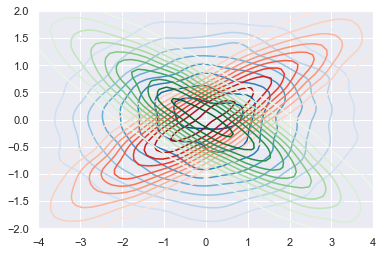

In [13]:
def compare_rhos():
    mu = np.zeros(2)
    sigma_x, sigma_y = 2., 1.
    for rho, cmap in zip((0., +0.9, -0.9), ('Blues', 'Reds', 'Greens')):
        C = create_2d_covariance(sigma_x, sigma_y, rho)
        X = generate_normal(mu, C, 10000)
        sns.kdeplot(X[:, 0], X[:, 1], cmap=cmap)
    plt.xlim(-4, +4)
    plt.ylim(-2, +2)
        
compare_rhos()

### Problem 5

Implement the following neural network layer using pytorch:
$$
\mathbf{x}_\text{out} = \tanh(W \mathbf{x}_\text{in} + \mathbf{b}) \; ,
$$
Note that this layer uses (element-wise) *tanh activation* instead of the *relu activation* from the example in class.

In [14]:
import torch

In [15]:
def xout(W, xin, b):
    x0 = xin.reshape(-1, 1)
    xm = W.mm(x0)
    x1 = xm.reshape(2,) + b
    return torch.tanh(x1)

In [16]:
# A correct solution should pass these tests.
W = torch.tensor([[1., 2., 3.], [2., -1., 0.]], requires_grad=True)
xin = torch.tensor([0.5, -0.5, 1])
b = torch.tensor([-1., 1.])
assert torch.allclose(xout(W, xin, b), torch.tensor([0.9051, 0.9866]), rtol=1e-4)